# Sentiment Analysis with LSTM

# 0-) IMPORTS

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import tensorflow        as tf
from tqdm                import tqdm

from tensorflow.keras.datasets               import mnist
from tensorflow.keras.models                 import Sequential
from tensorflow.keras.layers                 import LeakyReLU, Dense, Reshape, Conv2D, Flatten, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers             import Adam
from tensorflow.keras.callbacks              import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 1-) DATA ANALYSIS

In [2]:
(X_train,_), (_,_) = mnist.load_data() #We will only use X_train

In [3]:
X_train = X_train/255.0

In [4]:
print(X_train.shape)
print(len(X_train))

(60000, 28, 28)
60000


In [5]:
#Expand dimensions
X_train = np.expand_dims(X_train, axis=-1)

In [6]:
print(X_train.shape)
print(len(X_train))

(60000, 28, 28, 1)
60000


# 2-) MODELLING

## A-) Create discriminator and generator 

### a-) Discriminator

In [7]:
def build_discriminator():
    model = Sequential()
    #Feature Extraction
    model.add(Conv2D(filters    = 64,
                     kernel_size= (3,3),
                     strides    = 2, # We don't want to reduce data size and loss data.
                     padding    = "same", 
                     input_shape = (28,28,1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(filters    = 128,
                     kernel_size= (3,3),
                     strides    = 2, # We don't want to reduce data size and loss data.
                     padding    = "same"))
    model.add(LeakyReLU(alpha=0.2))
    #Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    #Compile
    model.compile(loss="binary_crossentropy",
                  optimizer=Adam(learning_rate = 1e-4,
                                 beta_1        = 0.5),
                  metrics   = [tf.keras.metrics.Precision(name="precision"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.AUC(name="auc"),
                               "accuracy"])
    return model

In [8]:
discriminator_model = build_discriminator()
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6273      
                                                                 
Total params: 80,769
Trainable params: 80,769
Non-traina

### b-) Generator

In [9]:
zdim = 100

In [10]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128,#Flatten dimension
              input_dim=zdim)) #From noisy vector transform to high level space
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))#transform into matris
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(filters    = 64,
                              kernel_size= (3,3),
                              strides    = 2, # We don't want to reduce data size and loss data.
                              padding    = "same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(filters    = 1,
                              kernel_size= (3,3),
                              strides    = 2, # We don't want to reduce data size and loss data.
                              padding    = "same",
                              activation = "tanh"))
    return model

In [11]:
generator_model = build_generator()
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       73792     
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)       

## B-) Create GAN model = discriminator + generator 

In [12]:
#Create gan model
def build_gan(generator, discriminator):
    discriminator.trainable = False # Don't train discriminator inside GAN

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss="binary_crossentropy",
                  optimizer=Adam(learning_rate = 1e-4,
                                 beta_1        = 0.5),
                  metrics   = [tf.keras.metrics.Precision(name="precision"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.AUC(name="auc"),
                               "accuracy"])
    return model 

In [13]:
GAN = build_gan(generator=generator_model,
                discriminator=discriminator_model)
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         708609    
                                                                 
 sequential (Sequential)     (None, 1)                 80769     
                                                                 
Total params: 789,378
Trainable params: 708,225
Non-trainable params: 81,153
_________________________________________________________________


## C-) Model Training

In [14]:
epochs     = 10000
batch_size = 64
half_batch = batch_size//2

In [15]:
# Training Cycle
for epoch in tqdm(range(epochs), desc="Training Process"):
    #Train Discriminator with real data
    idx         = np.random.randint(0,X_train.shape[0], half_batch) #select random images of half of the images of batchsize
    real_images = X_train[idx] #save real images
    real_labels = np.ones((half_batch,1)) #Label real data as 1 
    #Train Discriminator with fake data
    noise       = np.random.normal(0,1,(half_batch, zdim)) # noise image
    fake_images = generator_model.predict(noise,verbose=0) # generate fake images
    fake_labels = np.zeros((half_batch,1)) #Label fake data as 0
    #Update Discriminator
    d_loss_real = discriminator_model.train_on_batch(real_images,real_labels) #Calculate Loss with real data 
    d_loss_fake = discriminator_model.train_on_batch(fake_images,fake_labels) #Calculate Loss with fake data 
    d_loss      = np.add(d_loss_fake,d_loss_real)*0.5 #Average Loss
    #Train GAN
    noise   = np.random.normal(0,1,(batch_size,zdim))#create noise
    valid_y = np.ones((batch_size, 1)) #real values
    g_loss  = GAN.train_on_batch(noise, valid_y) #GAN loss
    #Print Training
    if epoch % 100 == 0:
        print(f"{epoch}/{epochs}, d_loss:{d_loss[0]}, g_loss:{g_loss[0]}\n")

Training Process:   0%|          | 3/10000 [00:01<1:09:46,  2.39it/s]

0/10000, d_loss:0.6949141025543213, g_loss:0.7071369886398315



Training Process:   1%|          | 103/10000 [00:10<15:02, 10.96it/s]

100/10000, d_loss:0.3676372766494751, g_loss:0.4341335594654083



Training Process:   2%|▏         | 203/10000 [00:18<13:24, 12.17it/s]

200/10000, d_loss:0.08517960272729397, g_loss:0.1192820817232132



Training Process:   3%|▎         | 303/10000 [00:26<13:10, 12.27it/s]

300/10000, d_loss:0.1397639960050583, g_loss:0.6441371440887451



Training Process:   4%|▍         | 403/10000 [00:34<13:16, 12.04it/s]

400/10000, d_loss:0.08349749445915222, g_loss:3.457542657852173



Training Process:   5%|▌         | 503/10000 [00:43<13:56, 11.35it/s]

500/10000, d_loss:0.08035402745008469, g_loss:3.13584303855896



Training Process:   6%|▌         | 603/10000 [00:51<12:51, 12.17it/s]

600/10000, d_loss:0.09365064650774002, g_loss:0.6767820119857788



Training Process:   7%|▋         | 703/10000 [00:59<12:55, 11.98it/s]

700/10000, d_loss:0.13002821803092957, g_loss:1.3172000646591187



Training Process:   8%|▊         | 803/10000 [01:08<13:01, 11.77it/s]

800/10000, d_loss:0.08175893314182758, g_loss:0.9479691982269287



Training Process:   9%|▉         | 901/10000 [01:17<13:41, 11.08it/s]

900/10000, d_loss:0.1959424838423729, g_loss:1.1405301094055176



Training Process:  10%|█         | 1003/10000 [01:26<13:05, 11.45it/s]

1000/10000, d_loss:0.20310060679912567, g_loss:1.9379833936691284



Training Process:  11%|█         | 1103/10000 [01:34<13:30, 10.98it/s]

1100/10000, d_loss:0.18014515191316605, g_loss:1.5825738906860352



Training Process:  12%|█▏        | 1203/10000 [01:43<12:46, 11.48it/s]

1200/10000, d_loss:0.24641361832618713, g_loss:1.721481204032898



Training Process:  13%|█▎        | 1303/10000 [01:52<12:20, 11.75it/s]

1300/10000, d_loss:0.16718366742134094, g_loss:1.600870132446289



Training Process:  14%|█▍        | 1403/10000 [02:00<12:00, 11.93it/s]

1400/10000, d_loss:0.1362016648054123, g_loss:1.7245248556137085



Training Process:  15%|█▌        | 1503/10000 [02:09<12:06, 11.70it/s]

1500/10000, d_loss:0.11803724616765976, g_loss:3.1998088359832764



Training Process:  16%|█▌        | 1603/10000 [02:17<11:30, 12.16it/s]

1600/10000, d_loss:0.10478262975811958, g_loss:2.445402145385742



Training Process:  17%|█▋        | 1703/10000 [02:25<11:06, 12.44it/s]

1700/10000, d_loss:0.1343933269381523, g_loss:2.2973196506500244



Training Process:  18%|█▊        | 1803/10000 [02:33<11:03, 12.36it/s]

1800/10000, d_loss:0.08177623525261879, g_loss:2.3305554389953613



Training Process:  19%|█▉        | 1903/10000 [02:42<11:42, 11.53it/s]

1900/10000, d_loss:0.12345540523529053, g_loss:2.9218382835388184



Training Process:  20%|██        | 2003/10000 [02:50<11:23, 11.71it/s]

2000/10000, d_loss:0.1296677626669407, g_loss:2.618849754333496



Training Process:  21%|██        | 2103/10000 [02:58<11:17, 11.65it/s]

2100/10000, d_loss:0.08396338671445847, g_loss:2.86274790763855



Training Process:  22%|██▏       | 2203/10000 [03:07<10:51, 11.97it/s]

2200/10000, d_loss:0.15235497802495956, g_loss:2.79593825340271



Training Process:  23%|██▎       | 2303/10000 [03:16<10:16, 12.48it/s]

2300/10000, d_loss:0.1085902750492096, g_loss:2.893702745437622



Training Process:  24%|██▍       | 2403/10000 [03:24<10:08, 12.49it/s]

2400/10000, d_loss:0.06856350600719452, g_loss:3.397319793701172



Training Process:  25%|██▌       | 2503/10000 [03:32<09:58, 12.53it/s]

2500/10000, d_loss:0.10931752622127533, g_loss:3.346771240234375



Training Process:  26%|██▌       | 2603/10000 [03:40<10:17, 11.98it/s]

2600/10000, d_loss:0.06899157911539078, g_loss:3.3818652629852295



Training Process:  27%|██▋       | 2703/10000 [03:49<10:06, 12.04it/s]

2700/10000, d_loss:0.10811632126569748, g_loss:2.933445692062378



Training Process:  28%|██▊       | 2803/10000 [03:57<10:10, 11.79it/s]

2800/10000, d_loss:0.08721645921468735, g_loss:3.482780933380127



Training Process:  29%|██▉       | 2903/10000 [04:06<09:47, 12.08it/s]

2900/10000, d_loss:0.15588447451591492, g_loss:4.014900207519531



Training Process:  30%|███       | 3003/10000 [04:14<09:52, 11.82it/s]

3000/10000, d_loss:0.03674984257668257, g_loss:5.13692569732666



Training Process:  31%|███       | 3103/10000 [04:22<09:40, 11.88it/s]

3100/10000, d_loss:0.07546378299593925, g_loss:4.055559158325195



Training Process:  32%|███▏      | 3203/10000 [04:31<09:39, 11.74it/s]

3200/10000, d_loss:0.06752632185816765, g_loss:2.747652530670166



Training Process:  33%|███▎      | 3303/10000 [04:39<09:27, 11.80it/s]

3300/10000, d_loss:0.059475403279066086, g_loss:3.4944028854370117



Training Process:  34%|███▍      | 3403/10000 [04:48<09:06, 12.07it/s]

3400/10000, d_loss:0.051121571101248264, g_loss:3.831092119216919



Training Process:  35%|███▌      | 3503/10000 [04:56<09:30, 11.39it/s]

3500/10000, d_loss:0.060387445613741875, g_loss:3.0330071449279785



Training Process:  36%|███▌      | 3603/10000 [05:05<08:35, 12.40it/s]

3600/10000, d_loss:0.08556893281638622, g_loss:2.856687545776367



Training Process:  37%|███▋      | 3703/10000 [05:13<08:26, 12.43it/s]

3700/10000, d_loss:0.08671277016401291, g_loss:3.8431777954101562



Training Process:  38%|███▊      | 3803/10000 [05:21<08:10, 12.63it/s]

3800/10000, d_loss:0.07973815500736237, g_loss:3.8934969902038574



Training Process:  39%|███▉      | 3903/10000 [05:29<08:01, 12.66it/s]

3900/10000, d_loss:0.08452683500945568, g_loss:4.129623889923096



Training Process:  40%|████      | 4003/10000 [05:37<08:22, 11.93it/s]

4000/10000, d_loss:0.04593282751739025, g_loss:6.051657676696777



Training Process:  41%|████      | 4103/10000 [05:45<08:03, 12.19it/s]

4100/10000, d_loss:0.04621521569788456, g_loss:3.8092284202575684



Training Process:  42%|████▏     | 4203/10000 [05:54<07:41, 12.57it/s]

4200/10000, d_loss:0.10808190703392029, g_loss:4.180712699890137



Training Process:  43%|████▎     | 4301/10000 [06:02<08:24, 11.30it/s]

4300/10000, d_loss:0.05019335076212883, g_loss:3.446702480316162



Training Process:  44%|████▍     | 4403/10000 [06:11<07:37, 12.24it/s]

4400/10000, d_loss:0.05643152445554733, g_loss:3.6799275875091553



Training Process:  45%|████▌     | 4503/10000 [06:20<07:45, 11.81it/s]

4500/10000, d_loss:0.08649147860705853, g_loss:4.332435607910156



Training Process:  46%|████▌     | 4603/10000 [06:28<07:26, 12.09it/s]

4600/10000, d_loss:0.059236930683255196, g_loss:4.418316841125488



Training Process:  47%|████▋     | 4701/10000 [06:36<07:37, 11.58it/s]

4700/10000, d_loss:0.050201062113046646, g_loss:6.3980817794799805



Training Process:  48%|████▊     | 4803/10000 [06:45<07:24, 11.70it/s]

4800/10000, d_loss:0.0646000076085329, g_loss:4.611470699310303



Training Process:  49%|████▉     | 4903/10000 [06:54<07:14, 11.73it/s]

4900/10000, d_loss:0.03077301848679781, g_loss:3.874364137649536



Training Process:  50%|█████     | 5003/10000 [07:02<06:45, 12.31it/s]

5000/10000, d_loss:0.08046650141477585, g_loss:3.4448330402374268



Training Process:  51%|█████     | 5103/10000 [07:10<06:54, 11.81it/s]

5100/10000, d_loss:0.04081388935446739, g_loss:4.471808433532715



Training Process:  52%|█████▏    | 5203/10000 [07:19<06:36, 12.09it/s]

5200/10000, d_loss:0.039336266461759806, g_loss:5.879683494567871



Training Process:  53%|█████▎    | 5303/10000 [07:27<06:26, 12.14it/s]

5300/10000, d_loss:0.016279064118862152, g_loss:3.1470143795013428



Training Process:  54%|█████▍    | 5403/10000 [07:35<06:19, 12.12it/s]

5400/10000, d_loss:0.04117685183882713, g_loss:6.551477432250977



Training Process:  55%|█████▌    | 5503/10000 [07:44<06:10, 12.15it/s]

5500/10000, d_loss:0.06525502353906631, g_loss:4.919885158538818



Training Process:  56%|█████▌    | 5603/10000 [07:52<06:06, 12.01it/s]

5600/10000, d_loss:0.06642763689160347, g_loss:4.760817527770996



Training Process:  57%|█████▋    | 5703/10000 [08:00<05:49, 12.30it/s]

5700/10000, d_loss:0.10457995533943176, g_loss:3.5182266235351562



Training Process:  58%|█████▊    | 5803/10000 [08:08<05:57, 11.76it/s]

5800/10000, d_loss:0.0893312394618988, g_loss:4.108271598815918



Training Process:  59%|█████▉    | 5903/10000 [08:17<06:02, 11.31it/s]

5900/10000, d_loss:0.015228298492729664, g_loss:5.002098083496094



Training Process:  60%|██████    | 6003/10000 [08:25<05:28, 12.17it/s]

6000/10000, d_loss:0.060602087527513504, g_loss:3.9153382778167725



Training Process:  61%|██████    | 6101/10000 [08:34<06:00, 10.81it/s]

6100/10000, d_loss:0.09285965375602245, g_loss:3.9350767135620117



Training Process:  62%|██████▏   | 6203/10000 [08:43<05:18, 11.92it/s]

6200/10000, d_loss:0.042009465862065554, g_loss:5.931522369384766



Training Process:  63%|██████▎   | 6301/10000 [08:51<05:30, 11.19it/s]

6300/10000, d_loss:0.06778904795646667, g_loss:5.150422096252441



Training Process:  64%|██████▍   | 6403/10000 [09:00<05:22, 11.16it/s]

6400/10000, d_loss:0.05867066793143749, g_loss:3.8975448608398438



Training Process:  65%|██████▌   | 6503/10000 [09:09<04:58, 11.73it/s]

6500/10000, d_loss:0.022589621134102345, g_loss:4.887215614318848



Training Process:  66%|██████▌   | 6603/10000 [09:17<04:42, 12.00it/s]

6600/10000, d_loss:0.10429040156304836, g_loss:4.599391460418701



Training Process:  67%|██████▋   | 6703/10000 [09:26<04:34, 11.99it/s]

6700/10000, d_loss:0.017414585454389453, g_loss:5.456385612487793



Training Process:  68%|██████▊   | 6803/10000 [09:34<04:21, 12.21it/s]

6800/10000, d_loss:0.042895421385765076, g_loss:4.078455448150635



Training Process:  69%|██████▉   | 6903/10000 [09:42<04:17, 12.01it/s]

6900/10000, d_loss:0.024018352443818003, g_loss:4.484347343444824



Training Process:  70%|███████   | 7003/10000 [09:51<04:18, 11.59it/s]

7000/10000, d_loss:0.08029445819556713, g_loss:3.8823065757751465



Training Process:  71%|███████   | 7101/10000 [09:59<04:05, 11.83it/s]

7100/10000, d_loss:0.08230563253164291, g_loss:3.8699636459350586



Training Process:  72%|███████▏  | 7203/10000 [10:08<03:48, 12.26it/s]

7200/10000, d_loss:0.022206817753612995, g_loss:4.098760604858398



Training Process:  73%|███████▎  | 7303/10000 [10:16<03:36, 12.44it/s]

7300/10000, d_loss:0.044411418959498405, g_loss:5.461543560028076



Training Process:  74%|███████▍  | 7403/10000 [10:24<03:35, 12.08it/s]

7400/10000, d_loss:0.05685741826891899, g_loss:3.5213780403137207



Training Process:  75%|███████▌  | 7503/10000 [10:33<03:23, 12.25it/s]

7500/10000, d_loss:0.051500530913472176, g_loss:6.718169689178467



Training Process:  76%|███████▌  | 7603/10000 [10:41<03:17, 12.11it/s]

7600/10000, d_loss:0.045214928686618805, g_loss:4.1578874588012695



Training Process:  77%|███████▋  | 7703/10000 [10:49<03:07, 12.24it/s]

7700/10000, d_loss:0.05058397352695465, g_loss:4.416855335235596



Training Process:  78%|███████▊  | 7801/10000 [10:57<03:02, 12.03it/s]

7800/10000, d_loss:0.0314300749450922, g_loss:5.497807025909424



Training Process:  79%|███████▉  | 7901/10000 [11:06<02:59, 11.71it/s]

7900/10000, d_loss:0.07925711432471871, g_loss:6.32417106628418



Training Process:  80%|████████  | 8001/10000 [11:14<03:10, 10.47it/s]

8000/10000, d_loss:0.041375722736120224, g_loss:3.579601287841797



Training Process:  81%|████████  | 8101/10000 [11:24<03:02, 10.42it/s]

8100/10000, d_loss:0.04915562644600868, g_loss:4.000138282775879



Training Process:  82%|████████▏ | 8203/10000 [11:33<02:31, 11.83it/s]

8200/10000, d_loss:0.0072641391307115555, g_loss:9.794440269470215



Training Process:  83%|████████▎ | 8303/10000 [11:41<02:21, 11.98it/s]

8300/10000, d_loss:0.02279535587877035, g_loss:5.503408432006836



Training Process:  84%|████████▍ | 8403/10000 [11:49<02:15, 11.78it/s]

8400/10000, d_loss:0.02929366915486753, g_loss:5.878693103790283



Training Process:  85%|████████▌ | 8503/10000 [11:58<02:07, 11.77it/s]

8500/10000, d_loss:0.0558597594499588, g_loss:4.08678674697876



Training Process:  86%|████████▌ | 8603/10000 [12:07<01:58, 11.74it/s]

8600/10000, d_loss:0.027159210294485092, g_loss:5.143492698669434



Training Process:  87%|████████▋ | 8703/10000 [12:16<01:55, 11.22it/s]

8700/10000, d_loss:0.05994820408523083, g_loss:4.777726650238037



Training Process:  88%|████████▊ | 8803/10000 [12:24<01:44, 11.48it/s]

8800/10000, d_loss:0.039997829124331474, g_loss:7.920448303222656



Training Process:  89%|████████▉ | 8903/10000 [12:33<01:36, 11.42it/s]

8900/10000, d_loss:0.028290002141147852, g_loss:3.851273775100708



Training Process:  90%|█████████ | 9003/10000 [12:42<01:24, 11.78it/s]

9000/10000, d_loss:0.054514939431101084, g_loss:4.6544189453125



Training Process:  91%|█████████ | 9103/10000 [12:50<01:12, 12.40it/s]

9100/10000, d_loss:0.017621910199522972, g_loss:5.230866432189941



Training Process:  92%|█████████▏| 9201/10000 [12:58<01:08, 11.65it/s]

9200/10000, d_loss:0.015122005017474294, g_loss:7.784749984741211



Training Process:  93%|█████████▎| 9302/10000 [13:07<00:56, 12.36it/s]

9300/10000, d_loss:0.010828635655343533, g_loss:4.989943504333496



Training Process:  94%|█████████▍| 9402/10000 [13:15<00:47, 12.48it/s]

9400/10000, d_loss:0.031597452238202095, g_loss:4.8258867263793945



Training Process:  95%|█████████▌| 9502/10000 [13:23<00:40, 12.44it/s]

9500/10000, d_loss:0.007487261900678277, g_loss:6.414016246795654



Training Process:  96%|█████████▌| 9602/10000 [13:31<00:35, 11.11it/s]

9600/10000, d_loss:0.02567053772509098, g_loss:5.215346813201904



Training Process:  97%|█████████▋| 9702/10000 [13:39<00:25, 11.63it/s]

9700/10000, d_loss:0.07995779532939196, g_loss:5.081345081329346



Training Process:  98%|█████████▊| 9802/10000 [13:48<00:17, 11.21it/s]

9800/10000, d_loss:0.025514451321214437, g_loss:7.719743728637695



Training Process:  99%|█████████▉| 9902/10000 [13:57<00:08, 12.01it/s]

9900/10000, d_loss:0.025661124847829342, g_loss:5.124143600463867



Training Process: 100%|██████████| 10000/10000 [14:05<00:00, 11.82it/s]


# 3-) MODEL TESTING

## 1-) Visualization

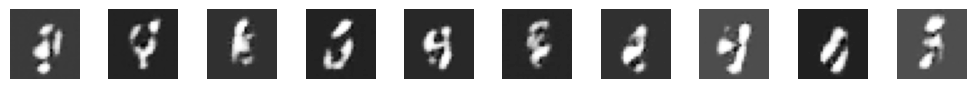

In [16]:
def plot_generated_images(generator, zdim, examples = 10, dim = (1,10)):
    noise = np.random.normal(0, 1, (examples, zdim)) #noise vectors
    generated_images = generator.predict(noise, verbose=0) #created images
    generated_images = 0.5*generated_images+0.5 #scale images

    plt.figure(figsize=(10,1))
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')#show in gray scale
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_generated_images(generator=generator_model,
                      zdim=zdim,
                      examples = 10, 
                      dim = (1,10))